# Speech Command Recognition 

This notebook presents an attention model for speech command recognotion. We use Google Speech Commands Dataset to test the Keras generator for sound files and the proposed RNN attention model.


## Download files and load information

Dynamically load speech data from the disk to allow handling big datasets.

First step: download Google Speech Command Dataset and convert all WAV files to numpy arrays for faster load (about 10x faster than loading raw WAV).

In [3]:
useColab=True
if useColab:
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechDownloader.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechGenerator.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/audioUtils.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechModels.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/requirements.txt
    !pip install -r requirements.txt

In [4]:
%load_ext autoreload
%autoreload 2

import librosa
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

import SpeechDownloader
import SpeechGenerator
import SpeechModels

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Using TensorFlow backend.


In [5]:
#Download and prepare all data
gscInfo, nCategs = SpeechDownloader.PrepareGoogleSpeechCmd(version=1, task = '35word')

  0%|          | 0.00/69.6k [00:00<?, ?KB/s]

69.6kKB [00:02, 31.0kKB/s]                           
  0%|          | 0.00/1.45M [00:00<?, ?KB/s]

1.45MKB [00:48, 30.1kKB/s]                           


Extracting sd_GSCmdV1/test.tar.gz into sd_GSCmdV1/test/
Extracting sd_GSCmdV1/train.tar.gz into sd_GSCmdV1/train/


  0%|          | 1/3081 [00:00<08:27,  6.06it/s]

Converting test set WAVs to numpy files


  0%|          | 0/64727 [00:00<?, ?it/s]

Converting training set WAVs to numpy files


100%|██████████| 64727/64727 [01:05<00:00, 991.28it/s]


Done preparing Google Speech commands dataset version 1


We should have 4 datasets, each with file names 'files' and their categories 'labels' in a dict.

In [6]:
print(gscInfo.keys())
print(gscInfo['train'].keys())
print(len(gscInfo['train']['files']))
print(nCategs)

dict_keys(['train', 'test', 'val', 'testREAL'])
dict_keys(['files', 'labels'])
51094
36


# Speech Data Generator

Use Keras to create a generator that reads files on the fly.

In [7]:
sr=16000 #we know this one for google audios
iLen = 16000
trainGen = SpeechGenerator.SpeechGen(gscInfo['train']['files'], gscInfo['train']['labels'], shuffle=True)
#handle the fact that number of samples in validation may not be multiple of batch_size with shuffle=True
valGen   = SpeechGenerator.SpeechGen(gscInfo['val']['files'], gscInfo['val']['labels'], shuffle=True)

#use batch_size = total number of files to read all test files at once
testGen  = SpeechGenerator.SpeechGen(gscInfo['test']['files'], gscInfo['test']['labels'], shuffle=False, batch_size=len(gscInfo['test']['files']))
testRGen = SpeechGenerator.SpeechGen(gscInfo['testREAL']['files'], gscInfo['testREAL']['labels'], shuffle=False, batch_size=len(gscInfo['testREAL']['files']))
valGen.__len__()

106

In [8]:
audios, classes = valGen.__getitem__(6)
classes

array([ 4, 29, 25, 19,  6,  1,  8,  7, 13, 11, 35, 11, 13, 11,  5, 11,  8,
       32,  6, 14,  1, 11, 23, 32, 32, 14, 29, 20, 33, 11, 11, 16, 15, 32,
       22,  1, 33, 25, 19,  2, 10,  1, 33, 33,  8, 24,  6,  5,  2,  3,  3,
        6, 14,  3, 20,  4, 14, 14, 10,  1, 11, 11,  6, 19])

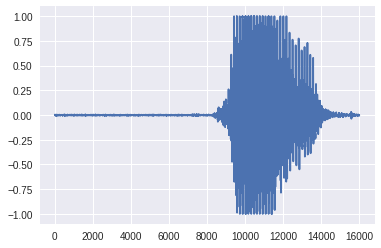

In [9]:
librosa.output.write_wav('file.wav', audios[5], sr, norm=False)
plt.plot(audios[5])

In [10]:
from keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D

melspecModel = Sequential()

melspecModel.add(Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, iLen),
                         padding='same', sr=sr, n_mels=80,
                         fmin=40.0, fmax=sr/2, power_melgram=1.0,
                         return_decibel_melgram=True, trainable_fb=False,
                         trainable_kernel=False,
                         name='mel_stft') )

melspecModel.add(Normalization2D(int_axis=0))

melspecModel.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mel_stft (Melspectrogram)    (None, 80, 125, 1)        1091664   
_________________________________________________________________
normalization2d_1 (Normaliza (None, 80, 125, 1)        0         
Total params: 1,091,664
Trainable params: 0
Non-trainable params: 1,091,664
_________________________________________________________________


In [11]:
melspec = melspecModel.predict( audios.reshape((-1,1,iLen)) )
melspec.shape

(64, 80, 125, 1)

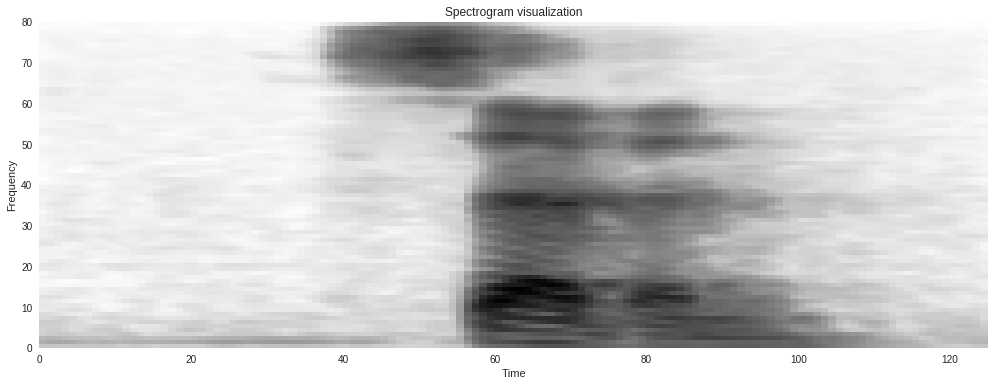

In [12]:
plt.figure(figsize=(17,6))
plt.pcolormesh(melspec[3,:,:,0])

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

(array([1.0530e+03, 6.9700e+02, 2.4400e+02, 9.9000e+01, 1.0400e+02,
        3.0500e+02, 2.0100e+02, 1.3900e+03, 3.8800e+02, 3.8500e+02,
        3.9100e+02, 4.0500e+02, 4.8800e+02, 6.9600e+02, 7.3100e+02,
        8.3900e+02, 5.2480e+03, 1.4480e+03, 1.8820e+03, 2.5900e+03,
        3.5900e+03, 4.8300e+03, 9.8420e+03, 1.0025e+04, 1.6280e+04,
        1.5897e+04, 1.9878e+04, 2.3040e+04, 2.4167e+04, 2.4958e+04,
        2.5222e+04, 2.5045e+04, 2.4058e+04, 2.3024e+04, 2.2339e+04,
        2.1365e+04, 2.0887e+04, 1.9336e+04, 1.8047e+04, 1.7027e+04,
        1.6967e+04, 1.6872e+04, 1.6153e+04, 1.4548e+04, 1.3331e+04,
        1.2881e+04, 1.2297e+04, 1.1913e+04, 1.1223e+04, 1.1137e+04,
        1.0659e+04, 9.9810e+03, 9.2440e+03, 8.6320e+03, 8.0690e+03,
        7.3260e+03, 6.7230e+03, 6.3420e+03, 5.8660e+03, 5.4310e+03,
        4.6690e+03, 4.2430e+03, 3.8970e+03, 3.2930e+03, 3.1720e+03,
        2.6220e+03, 2.4160e+03, 2.0860e+03, 1.7750e+03, 1.4980e+03,
        1.3220e+03, 1.0410e+03, 8.2100e+02, 6.80

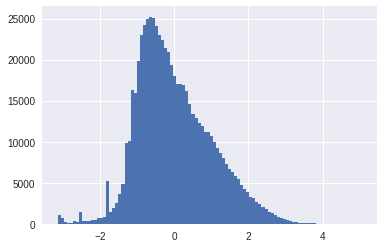

In [13]:
plt.hist(melspec.flatten(), bins=100)

# Models

Create Keras models to see if the generators are working properly

In [0]:
from keras.models import Model, load_model

from keras.layers import Input, Activation, Concatenate, Permute, Reshape, Flatten, Lambda, Dot, Softmax
from keras.layers import Add, Dropout, BatchNormalization, Conv2D, Reshape, MaxPooling2D, Dense, CuDNNLSTM, Bidirectional
from keras import backend as K
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras import optimizers

from kapre.time_frequency import Melspectrogram, Spectrogram

In [15]:
#self-attention LSTM
model = SpeechModels.AttRNNSpeechModel(nCategs, samplingrate = sr, inputLength = iLen)

model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000)        0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1, 16000)     0           input_1[0][0]                    
__________________________________________________________________________________________________
mel_stft (Melspectrogram)       (None, 80, 125, 1)   1091664     reshape_1[0][0]                  
__________________________________________________________________________________________________
normalization2d_2 (Normalizatio (None, 80, 125, 1)   0           mel_stft[0][0]                   
__________________________________________________________________________________________________
permute_1 

In [0]:
import math
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

In [0]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10, verbose=1)
checkpointer = ModelCheckpoint('model-attRNN.h5', monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)


In [21]:
results = model.fit_generator(trainGen, validation_data = valGen, epochs = 40, use_multiprocessing=True, workers=4,
                    callbacks=[earlystopper, checkpointer, lrate])

Epoch 1/40
Changing learning rate to 0.001
798/798 [==============================] - 113s 141ms/step - loss: 0.1411 - sparse_categorical_accuracy: 0.9602 - val_loss: 0.2987 - val_sparse_categorical_accuracy: 0.9166

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.91657, saving model to model-attRNN.h5

Epoch 1/40
Epoch 2/40
Changing learning rate to 0.001
798/798 [==============================] - 112s 140ms/step - loss: 0.1278 - sparse_categorical_accuracy: 0.9640 - val_loss: 0.3469 - val_sparse_categorical_accuracy: 0.9058

Epoch 00002: val_sparse_categorical_accuracy did not improve from 0.91657
Epoch 3/40
Changing learning rate to 0.001
798/798 [==============================] - 111s 139ms/step - loss: 0.1102 - sparse_categorical_accuracy: 0.9688 - val_loss: 0.2630 - val_sparse_categorical_accuracy: 0.9375

Epoch 00003: val_sparse_categorical_accuracy improved from 0.91657 to 0.93750, saving model to model-attRNN.h5
Epoch 4/40
Changing learning rate to 0.001
7

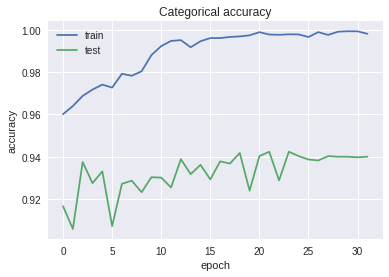

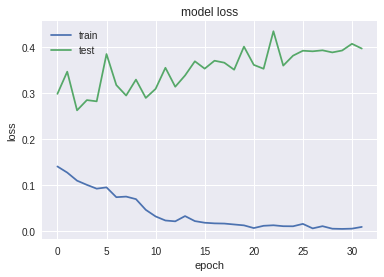

In [22]:
# summarize history for categorical accuracy
plt.plot(results.history['sparse_categorical_accuracy'])
plt.plot(results.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
results.history

{'loss': [0.14108855819287605,
  0.12780926377631555,
  0.11023513924792633,
  0.10114667435669175,
  0.09286970656714111,
  0.09569213012327325,
  0.07437589452753689,
  0.07565344662552456,
  0.0701589823961182,
  0.04690510223994999,
  0.032583385575472995,
  0.023768891028469494,
  0.021946004404476173,
  0.03336246574117855,
  0.022455225165298486,
  0.018916622052267285,
  0.01753668259360959,
  0.017101936976941123,
  0.015131563449442848,
  0.013200592886566522,
  0.007330614747011362,
  0.012268779575011527,
  0.013402587066753256,
  0.011382344953267363,
  0.011200748397737027,
  0.01638620019782382,
  0.006636090404069243,
  0.011433476561204426,
  0.005943817851521386,
  0.005478138479174207,
  0.006060604459952558,
  0.009814807116857454],
 'lr': [0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.0004,
  0.0004,
  0.0004,
  0.0004,
  0.0004,
  0.0004,
  0.0004,
  0.0004,
  0.0004,
  0.0004,
  0.00016,
  0.00016,
  0.00016,
  0.00016,
  0.00

In [0]:
#load best model according to cross-validation - model-attRNN
model = load_model('model-attRNN.h5', custom_objects={'Melspectrogram': Melspectrogram, 'Normalization2D': Normalization2D })

In [0]:
#read all test data
x_test, y_test = testGen.__getitem__(0)

In [26]:
valEval = model.evaluate_generator(valGen, use_multiprocessing=True, workers=4,verbose=1)
trainEval = model.evaluate_generator(trainGen, use_multiprocessing=True, workers=4,verbose=1)
testEval = model.evaluate(x_test, y_test, verbose=1)
print('Evaluation scores: \nMetrics: {} \nTrain: {} \nValidation: {} \nTest: {}'.format(model.metrics_names, trainEval, valEval, testEval) )

6835/6835 [==============================] - 12s 2ms/step
Evaluation scores: 
Metrics: ['loss', 'sparse_categorical_accuracy'] 
Train: [0.005637471954073054, 0.9993342731829574] 
Validation: [0.35440758863499144, 0.941185141509434] 
Test: [0.34499875927563595, 0.937966349670812]


In [27]:
#only for the Kaggle competition, 12-cmd
x_testR, y_testR = testRGen.__getitem__(0)
testREval = model.evaluate(x_testR, y_testR, verbose=1)
testREval

3081/3081 [==============================] - 7s 2ms/step


[1.8052397437967203, 0.8065563128854268]

In [28]:
testREval = model.evaluate_generator(testRGen, use_multiprocessing=True, workers=4,verbose=1)
testREval

1/1 [==============================] - 8s 8s/step


[1.804341197013855, 0.8068808913230896]

In [0]:
# Evaluation and Attention Plots

In [0]:
attSpeechModel = Model(inputs=model.input,
                                 outputs=[model.get_layer('output').output, 
                                          model.get_layer('attSoftmax').output,
                                          model.get_layer('mel_stft').output])


In [31]:
audios, classes = valGen.__getitem__(3)
classes

array([10,  1,  3, 15,  2, 14, 18, 11,  2, 18, 28,  9, 17,  4, 22, 11,  8,
       16,  7, 35,  2, 12, 22,  7, 14, 31, 23,  4, 12,  7, 20,  9,  4,  6,
        6, 10, 16,  1, 11, 14,  6, 14,  8, 18, 10,  4, 17,  3, 17, 10, 16,
        7, 13, 33,  6, 13, 35,  2, 16, 18, 33, 23, 17, 35])

In [32]:
#8 - on, 13 - one, 7 - right
idAudio = 8
classes[idAudio]

2

In [0]:
outs, attW, specs = attSpeechModel.predict( audios )

In [34]:
np.argmax(outs,axis=1)

array([10,  1,  3, 15,  2, 14, 18, 11,  2, 18, 28,  9, 17,  4, 22, 11,  8,
       16,  7, 35,  2, 12, 22,  7, 14, 31, 23,  4, 12,  7, 20,  9,  7,  6,
        6, 10, 16,  1, 11, 14,  6, 11,  8, 18, 10,  4, 17,  3, 17, 10, 16,
        7, 13, 33,  6, 13, 16,  2, 17, 18, 33, 23, 17, 35])

In [35]:
specs.shape

(64, 80, 125, 1)

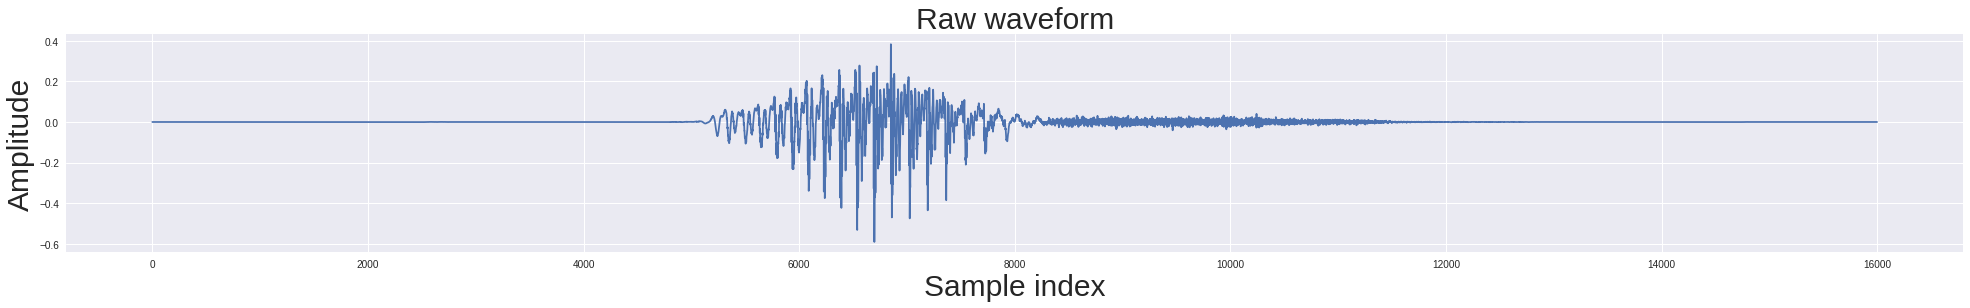

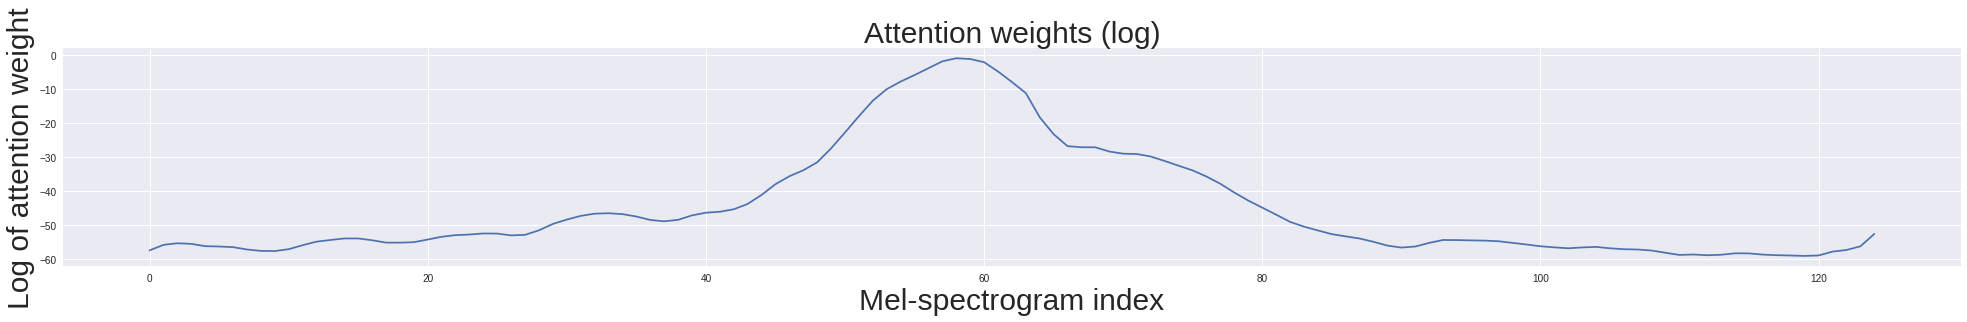

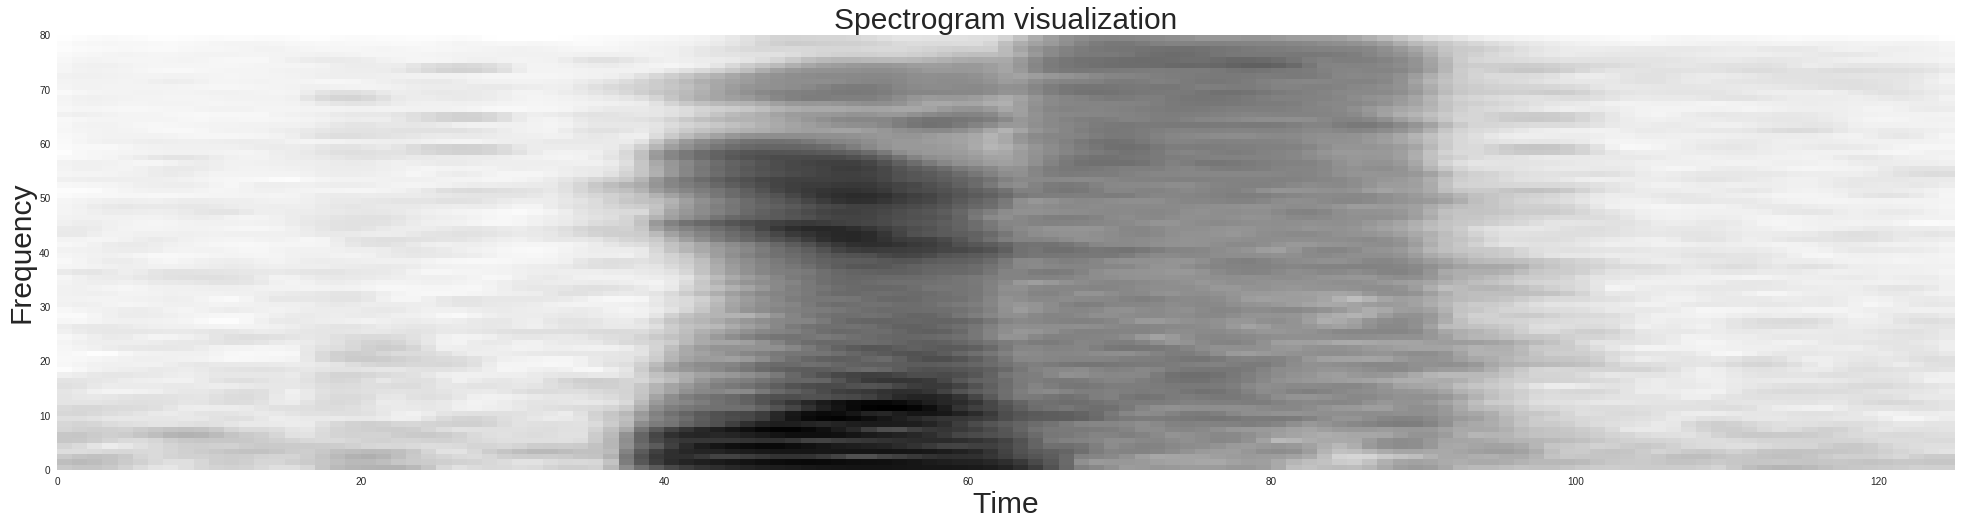

In [36]:

imgHeight = 2*2

plt.figure(figsize=(17*2,imgHeight))
plt.title('Raw waveform', fontsize=30)
plt.ylabel('Amplitude', fontsize=30)
plt.xlabel('Sample index', fontsize=30)
plt.plot(audios[idAudio])
plt.savefig('picrawWave.png', dpi = 400)
plt.show()

plt.figure(figsize=(17*2,imgHeight))
plt.title('Attention weights (log)', fontsize=30)
plt.ylabel('Log of attention weight', fontsize=30)
plt.xlabel('Mel-spectrogram index', fontsize=30)
plt.plot(np.log(attW[idAudio]))
plt.savefig('picAttention.png', dpi = 400)
plt.show()


plt.figure(figsize=(17*2,imgHeight*2))
plt.pcolormesh(specs[idAudio,:,:,0])

plt.title('Spectrogram visualization', fontsize=30)
plt.ylabel('Frequency', fontsize=30)
plt.xlabel('Time', fontsize=30)
plt.savefig('picmelSpec.png', dpi = 400)

plt.show()

In [37]:
y_pred = model.predict(x_test, verbose=1)

6835/6835 [==============================] - 15s 2ms/step


In [0]:
from sklearn.metrics import confusion_matrix
import audioUtils
cm = confusion_matrix(y_test, np.argmax(y_pred,1))

In [39]:
set(y_test)

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 22,
 23,
 24,
 25,
 28,
 29,
 31,
 32,
 33,
 35}

In [0]:
#35word, v2
classes = ['nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
           'zero', 'one', 'two', 'three', 'four', 'five', 'six', 
           'seven',  'eight', 'backward', 'bed', 'bird', 'cat', 'dog',
           'follow', 'forward', 'happy', 'house', 'learn', 'marvin', 'sheila', 'tree',
           'visual', 'wow']

In [0]:
#35word, v1
classes=['nine', 'yes',  'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
         'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',  'eight', 
         'bed', 'bird', 'cat', 'dog', 'happy', 'house', 
         'marvin', 'sheila', 'tree', 'wow']

In [0]:
#20cmd
classes=['unknown', 'nine', 'yes',  'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
         'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',  'eight', 'marvin', 'sheila']

/content/audioUtils.py:20: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


Normalized confusion matrix


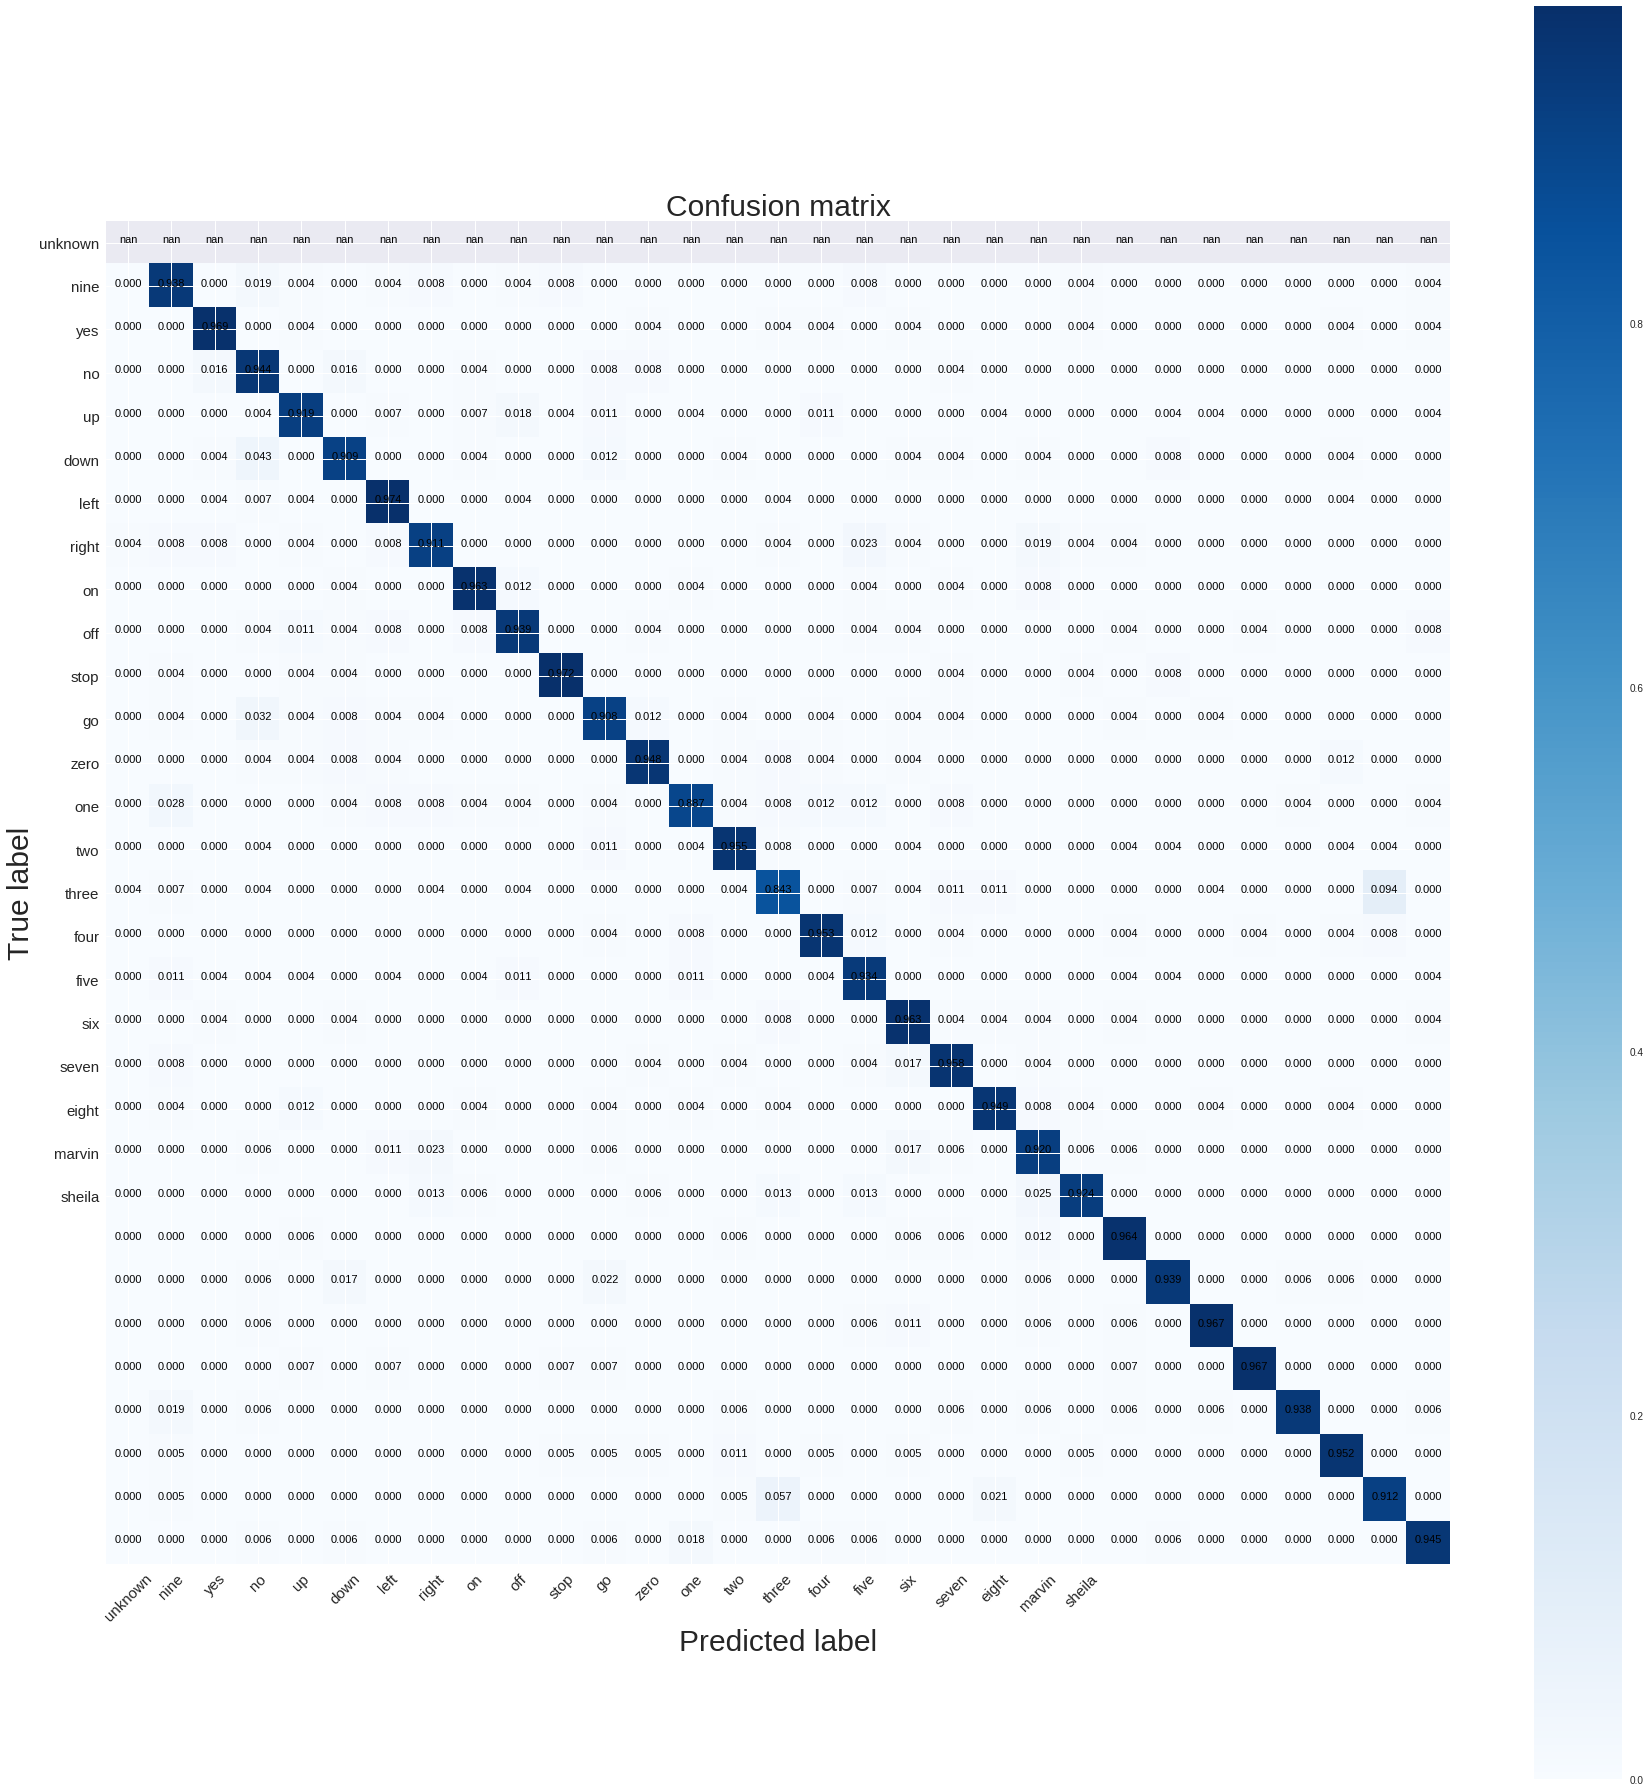

In [45]:
audioUtils.plot_confusion_matrix(cm,classes, normalize=True)